# Articulated "Spider" Localization

In this example, we define an articulated "spider" object made up of revolute joints with fixed (known) link lengths. The goal is to recover the distribution of the position of each link given noisy, multi-modal observations.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import os
import time
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch_bp.bp as bp
import torch_bp.distributions as dist

from torch_bp.graph import factors, MRFGraph
from torch_bp.util.spider import Spider
from torch_bp.inference.kernels import RBFMedianKernel
from torch_bp.util.plotting import plot_dists, plot_graph, plot_particles

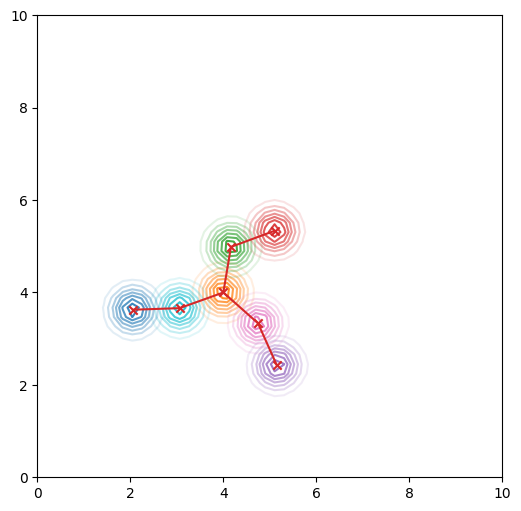

In [3]:
N = 7                  # Number of links in the spider.
OBS_SIGMA = 0.1        # Standard deviation for the observation of each node.
PAIR_ALPHA = 1         # Coefficient for the pairwise factor.
LIMS = [0, 10, 0, 10]  # Scene limits.
TENSOR_KWARGS = {"dtype": torch.float, "device": "cuda"}

edges = [(0, 1), (1, 4),
         (0, 2), (2, 5),
         (0, 3), (3, 6)]

# Utility class for computing spider link positions which respect the geometry.
spider = Spider(4, 4)  # Initialize at position (4, 4)

edge_factor = factors.DistancePairwiseFactor(spider.arm_length, alpha=PAIR_ALPHA)
g = MRFGraph(N, edges, edge_factors=edge_factor)  # Temporary, for visualization.

node_pos = np.array([link[:2] for link in spider.links])
node_obs = [dist.Gaussian(node_pos[i, :], OBS_SIGMA * torch.eye(2), **TENSOR_KWARGS) for i in range(g.N)]

plt.figure(figsize=(6, 6))
plot_dists(plt.gca(), node_obs, LIMS)
plot_graph(plt.gca(), node_pos, g)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

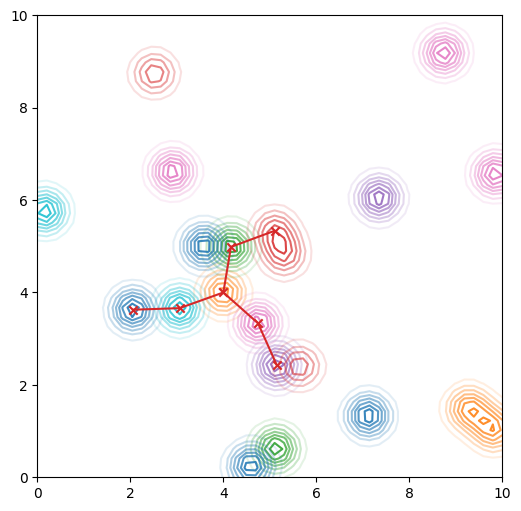

In [4]:
# Create Observation
NUM_OBS_RNG = [1, 4]

# Create some random noise.
num_obs = [np.random.randint(*NUM_OBS_RNG) for _ in range(N)]
means = [np.random.uniform(*LIMS[:2], (n, 2)) for n in num_obs]
# Add the true value to each observation.
means = [np.concatenate([m, np.expand_dims(s, 0)]) for m, s in zip(means, node_pos)]
sigs = [[OBS_SIGMA * np.eye(2) for _ in range(n + 1)] for n in num_obs]
obs = [dist.Mixture(m, sig, **TENSOR_KWARGS) for m, sig in zip(means, sigs)]

unary_factors = [factors.DistributionUnaryFactor(ob) for ob in obs]

g = MRFGraph(N, edges, edge_factors=edge_factor, unary_factors=unary_factors)

plt.figure(figsize=(6, 6))
plot_dists(plt.gca(), obs, LIMS)
plot_graph(plt.gca(), node_pos, g)
plt.xlim(*LIMS[:2])
plt.ylim(*LIMS[2:]);

## SVBP

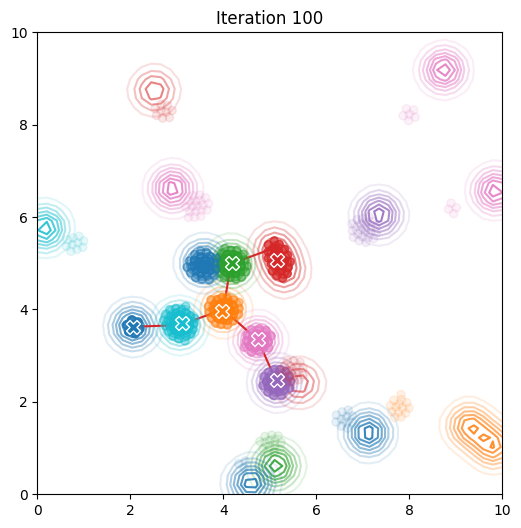

In [5]:
K = 50
INIT_SIGMA = 0.1
PAIR_ALPHA = 10.
LR = 0.1
ITERS = 100
COMPUTE_MLE = True
OUTPUT_DIR = "../output/spider/svbp"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Randomly initialize particles.
init_particles = torch.zeros(g.N, K, 2, **TENSOR_KWARGS).uniform_(*LIMS[:2])
rbf_kernel = RBFMedianKernel(sigma=0.05)
optim_type = torch.optim.Adam           # optimizer type
optim_params = {'lr': LR}               # optimizer params

svbp = bp.SVBP(init_particles, g, rbf_kernel, optim_type=optim_type, optim_kwargs=optim_params)

# Intermediate plotting function, called to plot particles at each iteration.
def plot_intermediate(solver, it, compute_mle=COMPUTE_MLE):
    mles = [] if compute_mle else None
    weights = [] if compute_mle else None
    if compute_mle:
        for s in range(solver.graph.N):
            w = solver.compute_belief_weights(s)
            x_s = solver.particles(s)[w.argmax(), :].cpu().numpy()
            mles.append(x_s)
            weights.append(w.detach())
        weights = torch.stack(weights).cpu()

    plt.figure(0, figsize=(6, 6))
    plt.cla()
    plt.clf()
    plt.title(f"Iteration {it + 1}")
    plot_particles(plt.gca(), solver.particles().cpu(), node_pos, graph=solver.graph,
                   dists=obs, weights=weights, mle=mles, lims=LIMS)

    plt.savefig(os.path.join(OUTPUT_DIR, f"iteration_{(it + 1):03}.jpg"))

# Plot the initial iteration.
plot_intermediate(svbp, -1, compute_mle=False)

# Solve the SVBP problem
particles = svbp.solve(num_iters=ITERS, iter_fn=plot_intermediate)

## PBP

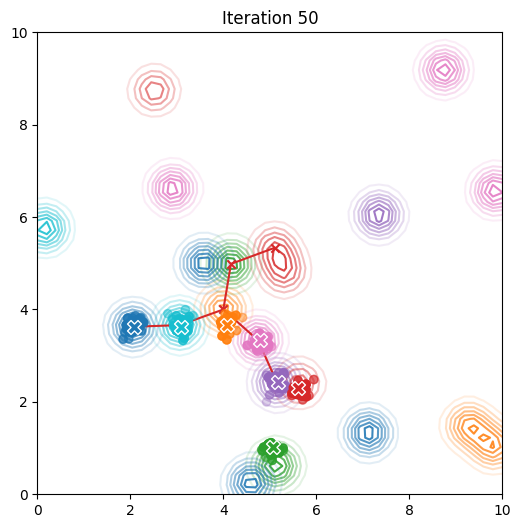

In [6]:
K = 50
ITERS = 50
JITTER = 0.05
INIT_SIGMA = 0.1
COMPUTE_MLE = True
OUTPUT_DIR = "../output/spider/pbp"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Randomly initialize particles.
init_particles = torch.zeros(N, K, 2, **TENSOR_KWARGS).uniform_(*LIMS[:2])
pbp = bp.ParticleBP(init_particles, g, tensor_kwargs=TENSOR_KWARGS)

# Plot the initial iteration.
plot_intermediate(pbp, -1, compute_mle=False)

# Solve the PBP problem.
particles = pbp.solve(num_iters=ITERS, jitter_sigma=JITTER, iter_fn=plot_intermediate)